In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
df = pd.read_csv('dataset.csv')

# Afficher les informations de base
print("Dimensions du dataset:", df.shape)
print("\nColonnes disponibles:")
print(df.columns.tolist())
print("\nTypes de données:")
print(df.dtypes)
print("\nValeurs manquantes:")
print(df.isnull().sum())

Dimensions du dataset: (114000, 21)

Colonnes disponibles:
['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']

Types de données:
Unnamed: 0            int64
track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object

Valeurs manquantes:
Unnamed: 0          0
t

In [4]:
features_numeriques = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 
    'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'explicit'
]

print("Vérification des valeurs manquantes:")
print(df[features_numeriques].isnull().sum())


X = df[features_numeriques]
y = df['popularity']

# Convertir explicit en numérique (False=0, True=1)
X['explicit'] = X['explicit'].astype(int)

correlations = df[features_numeriques + ['popularity']].corr()['popularity'].sort_values(ascending=False)
print("\nCorrélations avec la popularité:")
print(correlations)

Vérification des valeurs manquantes:
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
explicit            0
dtype: int64

Corrélations avec la popularité:
popularity          1.000000
loudness            0.050423
explicit            0.044082
danceability        0.035448
tempo               0.013205
energy              0.001056
key                -0.003853
liveness           -0.005387
duration_ms        -0.007101
mode               -0.013931
acousticness       -0.025472
valence            -0.040534
speechiness        -0.044927
instrumentalness   -0.095139
Name: popularity, dtype: float64


C:\Users\ludov\AppData\Local\Temp\ipykernel_19432\2773244268.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['explicit'] = X['explicit'].astype(int)


In [5]:
# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardiser les features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modèle 1: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Modèle 2: Régression linéaire
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Prédictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_lr = lr_model.predict(X_test_scaled)

# Évaluation
def evaluer_modele(y_true, y_pred, nom_modele):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\n{nom_modele}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {np.sqrt(mse):.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    return mse, r2, mae

print("=== COMPARAISON DES MODÈLES ===")
mse_lr, r2_lr, mae_lr = evaluer_modele(y_test, y_pred_lr, "Régression Linéaire")
mse_rf, r2_rf, mae_rf = evaluer_modele(y_test, y_pred_rf, "Random Forest")

=== COMPARAISON DES MODÈLES ===

Régression Linéaire:
MSE: 482.4789
RMSE: 21.9654
MAE: 18.3367
R²: 0.0223

Random Forest:
MSE: 219.9328
RMSE: 14.8301
MAE: 10.5177
R²: 0.5543


Random Forest est bien meilleur que la régression linéaire.  
Le modèle n'est tout de même pas encore entièrement satisfaisant.  
Nous allons donc essayer de l'améliorer. Essayons avec XGBoost :

In [6]:
# Modèle 3: XGBoost
'''xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)'''

xgb_no_scale = XGBRegressor(n_estimators=100, random_state=42)
xgb_no_scale.fit(X_train, y_train)

y_pred_xgb = xgb_no_scale.predict(X_test)

mse_xgb, r2_xgb, mae_xgb = evaluer_modele(y_test, y_pred_xgb, "XGBoost")


XGBoost:
MSE: 363.4444
RMSE: 19.0642
MAE: 15.2187
R²: 0.2635



Importance des features (Random Forest):
             feature  importance
6       acousticness    0.106159
0       danceability    0.100422
11       duration_ms    0.099939
10             tempo    0.098955
9            valence    0.098432
5        speechiness    0.097181
3           loudness    0.094664
1             energy    0.089323
8           liveness    0.085550
7   instrumentalness    0.071398
2                key    0.041532
4               mode    0.009338
12          explicit    0.007107


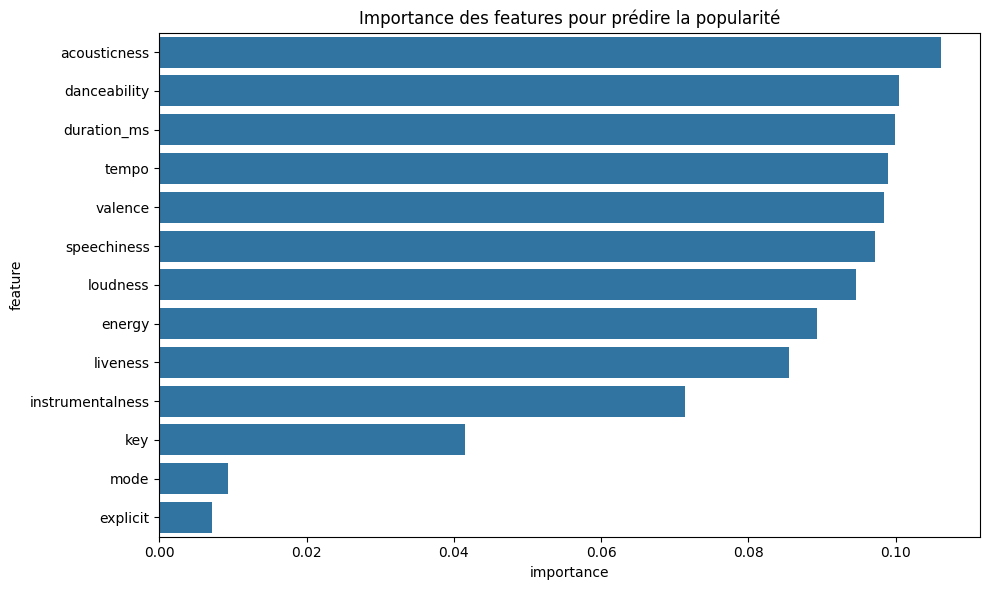

In [7]:
# Importance des features pour Random Forest
feature_importance = pd.DataFrame({
    'feature': features_numeriques,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nImportance des features (Random Forest):")
print(feature_importance)

# Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Importance des features pour prédire la popularité')
plt.tight_layout()
plt.show()

Features très importantes (>8%) :  

acousticness (10.6%) - La plus importante !  
danceability (10.0%)  
duration_ms (10.0%)  
tempo (9.9%)  
valence (9.8%)  
  
Features peu importantes (<5%) :  
  
key (4.2%)  
mode (0.9%) - Très faible  
explicit (0.7%) - Négligeable  